In [1]:
#LSST z-pred for realistic sims run with SALT3 on NERSC ugrizY

%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import astropy
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
from astropy.table import Table
import matplotlib
import glob

import time
import sys
import os
import pandas as pd

import astropy.units as u
from astropy.coordinates import Angle, SkyCoord, AltAz, EarthLocation
from astropy.time import Time
from astropy.coordinates import Angle

from scipy import interpolate

import galsim
from scipy import ndimage

# location of CTIO
earth_location = EarthLocation.of_site('La Silla Observatory')

print(earth_location)

(1838554.9580025, -5258914.42492168, -3099898.78073271) m


In [3]:
from scipy.stats import chi2
from scipy.interpolate import interp1d
from scipy.integrate import trapz

In [4]:
font = {'family' : 'serif', 'weight' : 'bold', 'style'  : 'normal', 'size'   : 12}
matplotlib.rc('font', **font)

In [5]:
ref_star_SED = np.loadtxt('/global/cfs/cdirs/des/jlee/SN_Ia/star_SEDs/ukk5v.dat')

f_source = interp1d(ref_star_SED.transpose()[0], ref_star_SED.transpose()[1])

LSST_bands = ['u', 'g', 'r', 'i', 'z', 'Y']
band_colors = ['blue', 'green', 'red', 'orange', 'violet']

SNANA_lsst_bands = []
for i in range(len(LSST_bands[:-1])):
    SNANA_lsst_bands.append(np.loadtxt('DCR_AstroZ/filter_functions/LSST_baseline_1.9/LSST_' + LSST_bands[i] + '.dat', skiprows = 7))


In [6]:
def sky_to_alt_az_coords(SN_fid_pos, mjd, loc = earth_location):
    coord0 = SkyCoord(SN_fid_pos[0] * u.deg, SN_fid_pos[1] * u.deg)
    aa = AltAz(location=loc, obstime=Time(mjd, scale = 'utc', format = 'mjd', location = loc))
    alt, az = coord0.transform_to(aa).alt, coord0.transform_to(aa).az 
    return alt, az

def sky_to_alt_az_shift(DCR_shift_RA, DCR_shift_DEC, SN_fid_pos, mjd, loc = earth_location):
    coord0 = SkyCoord(SN_fid_pos[0] * u.deg, SN_fid_pos[1] * u.deg)
    aa = AltAz(location=loc, obstime=Time(mjd, scale = 'utc', format = 'mjd', location = loc))
    coord = SkyCoord((coord0.ra.value + DCR_shift_RA) * u.deg, (coord0.dec.value + DCR_shift_DEC) * u.deg)
    alt_shift, az_shift = coord.transform_to(aa).alt - coord0.transform_to(aa).alt, coord.transform_to(aa).az - coord0.transform_to(aa).az
    return alt_shift, az_shift

def find_nearest(array, values):
    array = np.asarray(array)
    idxs = np.zeros(len(values))
    for i in range(len(values)):
        idxs[i] = (np.abs(array - values[i])).argmin()
    idxs = idxs.astype(int)
    return idxs, array[idxs]

In [7]:
dir_str = 'JASON_DCR_ASTROZ_COADD_REALISTIC_v1113/'
SIM_dir_str = '/pscratch/sd/a/astjason/DCR_AstroZ/' + dir_str
t_head = Table.read(glob.glob(SIM_dir_str + '*HEAD.FITS*')[0])
t_phot = Table.read(glob.glob(SIM_dir_str + '*PHOT.FITS*')[0])
t_DCR = pd.read_csv(glob.glob(SIM_dir_str + '*.DCR*')[0], delim_whitespace=True, skiprows = 6)
t_DUMP = pd.read_csv(glob.glob(SIM_dir_str + '*.DUMP*')[0], delim_whitespace=True, skiprows = 5)

In [8]:
t_head

SNID,IAUC,FAKE,RA,DEC,RA_AVG_u,RA_AVG_g,RA_AVG_r,RA_AVG_i,RA_AVG_z,RA_AVG_Y,DEC_AVG_u,DEC_AVG_g,DEC_AVG_r,DEC_AVG_i,DEC_AVG_z,DEC_AVG_Y,PIXSIZE,NXPIX,NYPIX,SNTYPE,NOBS,PTROBS_MIN,PTROBS_MAX,MWEBV,MWEBV_ERR,REDSHIFT_HELIO,REDSHIFT_HELIO_ERR,REDSHIFT_FINAL,REDSHIFT_FINAL_ERR,VPEC,VPEC_ERR,HOSTGAL_NMATCH,HOSTGAL_NMATCH2,HOSTGAL_OBJID,HOSTGAL_FLAG,HOSTGAL_PHOTOZ,HOSTGAL_PHOTOZ_ERR,HOSTGAL_SPECZ,HOSTGAL_SPECZ_ERR,HOSTGAL_RA,HOSTGAL_DEC,HOSTGAL_SNSEP,HOSTGAL_DDLR,HOSTGAL_CONFUSION,HOSTGAL_LOGMASS,HOSTGAL_LOGMASS_ERR,HOSTGAL_LOGSFR,HOSTGAL_LOGSFR_ERR,HOSTGAL_LOGsSFR,HOSTGAL_LOGsSFR_ERR,HOSTGAL_COLOR,HOSTGAL_COLOR_ERR,HOSTGAL_ELLIPTICITY,HOSTGAL_OBJID2,HOSTGAL_SQRADIUS,HOSTGAL_OBJID_UNIQUE,HOSTGAL_ZPHOT_Q000,HOSTGAL_ZPHOT_Q010,HOSTGAL_ZPHOT_Q020,HOSTGAL_ZPHOT_Q030,HOSTGAL_ZPHOT_Q040,HOSTGAL_ZPHOT_Q050,HOSTGAL_ZPHOT_Q060,HOSTGAL_ZPHOT_Q070,HOSTGAL_ZPHOT_Q080,HOSTGAL_ZPHOT_Q090,HOSTGAL_ZPHOT_Q100,HOSTGAL_MAG_u,HOSTGAL_MAG_g,HOSTGAL_MAG_r,HOSTGAL_MAG_i,HOSTGAL_MAG_z,HOSTGAL_MAG_Y,HOSTGAL_MAGERR_u,HOSTGAL_MAGERR_g,HOSTGAL_MAGERR_r,HOSTGAL_MAGERR_i,HOSTGAL_MAGERR_z,HOSTGAL_MAGERR_Y,HOSTGAL2_OBJID,HOSTGAL2_FLAG,HOSTGAL2_PHOTOZ,HOSTGAL2_PHOTOZ_ERR,HOSTGAL2_SPECZ,HOSTGAL2_SPECZ_ERR,HOSTGAL2_RA,HOSTGAL2_DEC,HOSTGAL2_SNSEP,HOSTGAL2_DDLR,HOSTGAL2_LOGMASS,HOSTGAL2_LOGMASS_ERR,HOSTGAL2_LOGSFR,HOSTGAL2_LOGSFR_ERR,HOSTGAL2_LOGsSFR,HOSTGAL2_LOGsSFR_ERR,HOSTGAL2_COLOR,HOSTGAL2_COLOR_ERR,HOSTGAL2_ELLIPTICITY,HOSTGAL2_OBJID2,HOSTGAL2_SQRADIUS,HOSTGAL2_OBJID_UNIQUE,HOSTGAL2_MAG_u,HOSTGAL2_MAG_g,HOSTGAL2_MAG_r,HOSTGAL2_MAG_i,HOSTGAL2_MAG_z,HOSTGAL2_MAG_Y,HOSTGAL2_MAGERR_u,HOSTGAL2_MAGERR_g,HOSTGAL2_MAGERR_r,HOSTGAL2_MAGERR_i,HOSTGAL2_MAGERR_z,HOSTGAL2_MAGERR_Y,HOSTGAL2_ZPHOT_Q000,HOSTGAL2_ZPHOT_Q010,HOSTGAL2_ZPHOT_Q020,HOSTGAL2_ZPHOT_Q030,HOSTGAL2_ZPHOT_Q040,HOSTGAL2_ZPHOT_Q050,HOSTGAL2_ZPHOT_Q060,HOSTGAL2_ZPHOT_Q070,HOSTGAL2_ZPHOT_Q080,HOSTGAL2_ZPHOT_Q090,HOSTGAL2_ZPHOT_Q100,HOSTGAL_SB_FLUXCAL_u,HOSTGAL_SB_FLUXCAL_g,HOSTGAL_SB_FLUXCAL_r,HOSTGAL_SB_FLUXCAL_i,HOSTGAL_SB_FLUXCAL_z,HOSTGAL_SB_FLUXCAL_Y,PEAKMJD,MJD_TRIGGER,MJD_DETECT_FIRST,MJD_DETECT_LAST,SEARCH_TYPE,SIM_MODEL_NAME,SIM_MODEL_INDEX,SIM_GENTYPE,SIM_TYPE_INDEX,SIM_TYPE_NAME,SIM_TEMPLATE_INDEX,SIM_LIBID,SIM_NGEN_LIBID,SIM_NOBS_UNDEFINED,SIM_SEARCHEFF_MASK,SIM_REDSHIFT_HELIO,SIM_REDSHIFT_CMB,SIM_REDSHIFT_HOST,SIM_REDSHIFT_FLAG,SIM_VPEC,SIM_HOSTLIB_GALID,SIM_HOSTLIB(LOGMASS_TRUE),SIM_HOSTLIB(LOG_SFR),SIM_DLMU,SIM_LENSDMU,SIM_RA,SIM_DEC,SIM_MWEBV,SIM_PEAKMJD,SIM_MJD_EXPLODE,SIM_MAGSMEAR_COH,SIM_AV,SIM_RV,SIM_SALT2x0,SIM_SALT2x1,SIM_SALT2c,SIM_SALT2mB,SIM_SALT2alpha,SIM_SALT2beta,SIM_SALT2gammaDM,SIM_PEAKMAG_u,SIM_PEAKMAG_g,SIM_PEAKMAG_r,SIM_PEAKMAG_i,SIM_PEAKMAG_z,SIM_PEAKMAG_Y,SIM_EXPOSURE_u,SIM_EXPOSURE_g,SIM_EXPOSURE_r,SIM_EXPOSURE_i,SIM_EXPOSURE_z,SIM_EXPOSURE_Y,SIM_GALFRAC_u,SIM_GALFRAC_g,SIM_GALFRAC_r,SIM_GALFRAC_i,SIM_GALFRAC_z,SIM_GALFRAC_Y,SIM_SUBSAMPLE_INDEX
bytes16,bytes16,int16,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,int16,int16,int32,int32,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int64,int16,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,int16,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,bytes32,int16,int16,int16,bytes8,int32,int32,int32,int32,int32,float32,float32,float32,int16,float32,

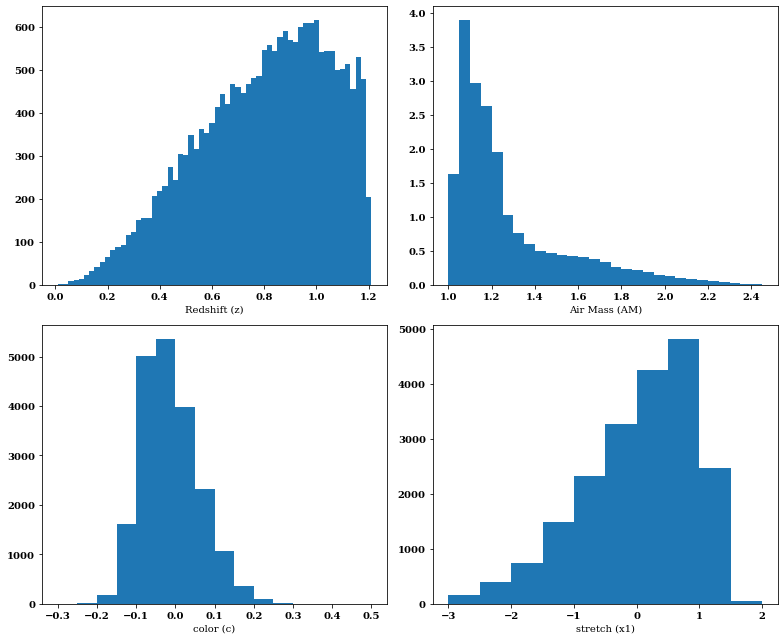

In [8]:
z_range = np.arange(0.01, 1.22, 0.02)
x1_vals, x1_vals_bins = np.arange(-3.0, 2.5, 0.5), np.arange(-3.0, 3.0, 0.5) - 0.5/2
c_vals, c_vals_bins = np.arange(-0.3, 0.55, 0.05), np.arange(-0.3, 0.60, 0.05) - 0.05/2

plt.subplots(2, 2, figsize = [11, 9])

plt.subplot(2, 2, 1)
plt.hist(t_head['REDSHIFT_FINAL'], bins = z_range);
plt.xlabel('Redshift (z)')

plt.subplot(2, 2, 2)
plt.hist(t_DCR['AIRMASS'].values, density = True, bins = np.arange(1.0, 2.5, 0.05))
plt.xlabel('Air Mass (AM)')

plt.subplot(2, 2, 3)
plt.hist(t_head['SIM_SALT2c'], bins = c_vals)
plt.xlabel('color (c)')

plt.subplot(2, 2, 4)
plt.hist(t_head['SIM_SALT2x1'], bins = x1_vals)
plt.xlabel('stretch (x1)')


plt.tight_layout()

In [9]:
c_prior = np.histogram(t_head['SIM_SALT2c'], bins = c_vals_bins, density = True)[0]
x1_prior = np.histogram(t_head['SIM_SALT2x1'], bins = x1_vals_bins, density = True)[0]

In [10]:
#DCR properties: CID, MJD, BAND, LAMAVG_SED_WGTED, SNR, PSF_FWHM, TOBS, AIRMASS, SIM_DCR are important


In [11]:
z_range, z_bin_CIDs = np.linspace(0.00, 1.2, num = 13), []
for i in range(len(z_range)-1):
    z_bin_inds = np.where((t_head['REDSHIFT_FINAL'] > z_range[i]) & (t_head['REDSHIFT_FINAL'] < z_range[i+1]) )[0]
    z_bin_CIDs.append(t_head['SNID'][z_bin_inds].astype(int).value)

In [12]:
where_bands = []

for b in range(len(LSST_bands)):
    where_bands.append(np.where(t_DCR['BAND'] == LSST_bands[b])[0])

In [13]:
t_DCR_inds_CID = np.load('DCR_AstroZ/' + dir_str + 't_DCR_inds_CID.npy', allow_pickle=True)
t_DCR_inds_band_CID = np.load('DCR_AstroZ/' + dir_str + 't_DCR_inds_band_CID.npy', allow_pickle=True)

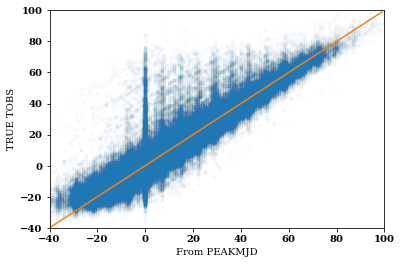

In [14]:
def flatten_comprehension(matrix):
    return [item for row in matrix for item in row]

TOBS_real = []

for i in range(len(t_head)):
    TOBS_real.append(t_DCR['MJD'].values[t_DCR_inds_CID[i]] - t_head['PEAKMJD'][i])
    
tobs_obs = np.array(flatten_comprehension(TOBS_real))

plt.plot(tobs_obs, t_DCR['TOBS'], '.', alpha = 0.01)
plt.plot(np.arange(-40, 100), np.arange(-40, 100))
plt.xlabel('From PEAKMJD')
plt.ylabel('TRUE TOBS')

plt.xlim(-40, 100)
plt.ylim(-40, 100)

#tobs_obs = np.loadtxt('/pscratch/sd/a/astjason/DCR_AstroZ/' + dir_str + 'TOBS_obs.txt')

where_epoch_condition = []
for h in range(len(t_head)):
    if TOBS_real[h].min() >= -3/2.2 or TOBS_real[h].max() <= 10/2.2:
        pass
    else:
        where_epoch_condition.append(h)
        

In [15]:
z_true = t_head['REDSHIFT_FINAL']

In [16]:
t_DCR = pd.read_csv('DCR_AstroZ/' + dir_str + dir_str[:-1] + '_with_band_obs.csv')
AM_range = np.arange(1.00, 3.00, 0.01)

In [17]:
#Run only the first time

t_st = time.time()

SNRs_all = [] #np.zeros([len(t_heads[0]), len(DES_bands)])
no_obs_all = np.zeros([len(t_head), len(LSST_bands)])
AMs_all = []

for head_ind in range(len(t_head)): #range(len(t_heads[0])): #range(20):
    SNID_sim = int(t_head[head_ind]['SNID'])
    t_DCR_band_inds_used = t_DCR_inds_band_CID[len(LSST_bands)*head_ind:len(LSST_bands)*(head_ind+1)] #[]
    
    if head_ind % 5000 == 0:
        print(time.time() - t_st, head_ind)
    
    #For one SN candidate
    SNRs_band, AMs_band = [], []
    for i in range(len(LSST_bands)):
        AM_inds = find_nearest(AM_range, t_DCR['AIRMASS'].values[t_DCR_band_inds_used[i]])[0]
        SNRs_band.append(t_DCR['SNR'].values[t_DCR_band_inds_used[i]])
        no_obs_all[head_ind][i] = len(SNRs_band[i])
        AMs_band.append(t_DCR['AIRMASS'].values[t_DCR_band_inds_used[i]])
    SNRs_all.append(SNRs_band)
    AMs_all.append(AMs_band)

0.00041675567626953125 0
0.6112618446350098 5000
1.1498851776123047 10000
1.703920841217041 15000


In [18]:
np.savetxt('DCR_AstroZ/' + dir_str + dir_str[:-1] + '_no_obs_all.txt', no_obs_all)
np.save('DCR_AstroZ/' + dir_str + dir_str[:-1] + '_SNRs_all.npy', SNRs_all)
np.save('DCR_AstroZ/' + dir_str + dir_str[:-1] + '_AMs_all.npy', AMs_all)

#no_obs_all = np.loadtxt('DCR_AstroZ/' + dir_str + dir_str[:-1] + '_no_obs_all.txt')
#SNRs_all = np.load('DCR_AstroZ/' + dir_str + dir_str[:-1] + '_SNRs_all.npy', allow_pickle=True)
#AMs_all = np.load('DCR_AstroZ/' + dir_str + dir_str[:-1] + '_AMs_all.npy', allow_pickle=True)

/global/homes/a/astjason/.conda/envs/SN_Ia/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


Text(0.5, 0, '# obs per SN Ia where epoch condition')

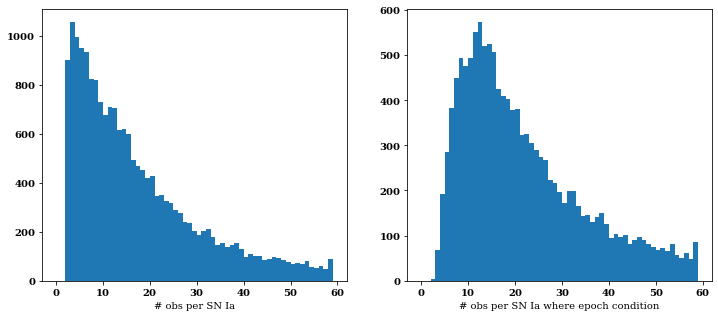

In [19]:
plt.subplots(1, 2, figsize = [12, 5])

plt.subplot(1, 2, 1)
plt.hist(no_obs_all.transpose()[:-1].sum(axis = 0), bins = np.arange(60))
plt.xlabel('# obs per SN Ia')

plt.subplot(1, 2, 2)
plt.hist(no_obs_all[where_epoch_condition].transpose()[:-1].sum(axis = 0), bins = np.arange(60))
plt.xlabel('# obs per SN Ia where epoch condition')


In [20]:
#For realistic sims only

where_SNR_selection_cut = []

SNR_cut_obs = 8

for head_ind in range(len(t_head)):
    for b in range(len(LSST_bands)):
        if len(np.where(SNRs_all[head_ind][b] >= SNR_cut_obs)[0]) != 0:
            where_SNR_selection_cut.append(head_ind)
            
where_SNR_stringent_cut = []
for head_ind in range(len(t_head)):
    if where_SNR_selection_cut.count(head_ind) >= 3:
        where_SNR_stringent_cut.append(head_ind)
        
where_SNR_stringent_cut_array = np.array(where_SNR_stringent_cut)


min_AM = 1.4
where_AM_selection_cut = []
for head_ind in range(len(t_head)):
    for b in range(len(LSST_bands)):
        if len(np.where(AMs_all[head_ind][b] > min_AM)[0]) != 0:
            where_AM_selection_cut.append(head_ind)
            
where_AM_stringent_cut = []
for head_ind in range(len(t_head)):
    if where_AM_selection_cut.count(head_ind) >= 1:
        where_AM_stringent_cut.append(head_ind)
        
where_AM_stringent_cut_array = np.array(where_AM_stringent_cut)



In [21]:
where_epoch_and_SNR = np.intersect1d(where_epoch_condition, where_SNR_stringent_cut)
len(where_epoch_and_SNR)

8622

In [22]:
where_epoch_and_SNR_and_AM = np.intersect1d(where_epoch_and_SNR, where_AM_stringent_cut)

In [23]:
z_range = np.arange(0.00, 1.21, 0.01)

In [24]:
#lcfit_CIDs = np.loadtxt(SIM_dir_str + 'lcfit_CIDs.txt')
#tobs_lcfit = np.loadtxt(SIM_dir_str + 'lcfit_TOBS.txt')
lcfit_CIDs_3iter = np.loadtxt(SIM_dir_str + 'lcfit_CIDs_v240111.txt')
tobs_lcfit_3iter = np.loadtxt(SIM_dir_str + 'lcfit_TOBS_v240111.txt')


In [25]:
#Getting rid of SNe where predicted z = 0.01 because of all the NaNs
def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])"""
    return np.isnan(y), lambda z: z.nonzero()[0]

In [26]:
def z_pred(chi2_all, z_range, host_photo_z, no_obs_all = no_obs_all, sig = 0.34135, zmin = 0.00, zmax = 1.2001, zprecision = 1e-4, no_quantiles = 11):
    z_interp = np.arange(zmin, zmax, zprecision)
    z_pred_CDF50, z_pred_peaks = np.zeros([len(chi2_all), 3]), np.zeros([len(chi2_all), 3]) #value, +- 1sigma
    z_quantiles = np.zeros([len(chi2_all), no_quantiles])
    total_post = np.zeros([len(chi2_all), len(z_range)])
    for h in range(len(chi2_all)):
        where_not_zero = np.where(no_obs_all[h][:-1] > 0)[0]
        chi2_sum = chi2_all[h][where_not_zero].sum(axis = 0)
        total_post[h] = trapz(trapz(np.exp(-chi2_sum/2)*c_prior, c_vals)*x1_prior, x1_vals)
        nans, x= nan_helper(total_post[h])
        if len(np.where(nans)[0]) != 0:
            if len(np.where(nans)[0]) == len(z_range):
                continue
            total_post[h][nans]= np.interp(x(nans), x(~nans), total_post[h][~nans])
        if total_post[h].mean() == 0:
            total_post[h] = np.ones(len(z_range))
        if host_photo_z[h].mean() == 0:
            host_photo_z[h] = np.ones(len(z_range))
        total_post[h] = total_post[h] * host_photo_z[h]
        max_ind = np.argmax(total_post[h])
        max_ind_z_interp = np.where(np.round(z_interp, 5) == np.round(z_range[max_ind], 2))[0]
        cdf = interp1d(z_range, np.cumsum(total_post[h])/np.sum(total_post[h]), fill_value='extrapolate')
        z_pred_CDF50[h] = z_interp[find_nearest(cdf(z_interp), [0.5, 0.5 - sig, 0.5 + sig])[0]]
        z_pred_peaks[h] = z_interp[find_nearest(cdf(z_interp), [cdf(z_interp[max_ind_z_interp]), cdf(z_interp[max_ind_z_interp]) - sig, cdf(z_interp[max_ind_z_interp]) + sig])[0]]
        z_quantiles[h] = z_interp[find_nearest(cdf(z_interp), np.linspace(0, 1, num = no_quantiles))[0]]
    return z_pred_CDF50, z_pred_peaks, total_post, z_quantiles

In [27]:
def z_pred_photoz(host_photo_z, z_range, sig = 0.34135, zmin = 0.00, zmax = 1.2001, zprecision = 1e-4):
    z_interp = np.arange(zmin, zmax, zprecision)
    z_pred_CDF50, z_pred_peaks = np.zeros([len(host_photo_z), 3]), np.zeros([len(host_photo_z), 3]) #value, +- 1sigma
    for h in range(len(host_photo_z)):
        if host_photo_z[h].mean() == 0:
            host_photo_z[h] = np.ones(len(z_range))
        max_ind = np.argmax(host_photo_z[h])
        max_ind_z_interp = np.where(np.round(z_interp, 5) == np.round(z_range[max_ind], 2))[0]
        cdf = interp1d(z_range, np.cumsum(host_photo_z[h])/np.sum(host_photo_z[h]), fill_value='extrapolate')
        z_pred_CDF50[h] = z_interp[find_nearest(cdf(z_interp), [0.5, 0.5 - sig, 0.5 + sig])[0]]
        z_pred_peaks[h] = z_interp[find_nearest(cdf(z_interp), [cdf(z_interp[max_ind_z_interp]), cdf(z_interp[max_ind_z_interp]) - sig, cdf(z_interp[max_ind_z_interp]) + sig])[0]]
    return z_pred_CDF50, z_pred_peaks, host_photo_z

In [28]:
def combine_pdfs(astro_z, host_photo_z, z_range, sig = 0.34135, zmin = 0.00, zmax = 1.2001, zprecision = 1e-4, no_quantiles = 11):
    z_interp = np.arange(zmin, zmax, zprecision)
    z_pred_CDF50, z_pred_peaks = np.zeros([len(astro_z), 3]), np.zeros([len(astro_z), 3]) #value, +- 1sigma
    total_post, z_quantiles = np.zeros([len(astro_z), len(z_range)]), np.zeros([len(astro_z), no_quantiles])
    for h in range(len(astro_z)):
        nans, x= nan_helper(astro_z[h])
        if len(np.where(nans)[0]) != 0:
            if len(np.where(nans)[0]) == len(z_range):
                continue
            astro_z[h][nans]= np.interp(x(nans), x(~nans), total_post[h][~nans])
        if astro_z[h].mean() == 0:
            astro_z[h] = np.ones(len(z_range))
        if host_photo_z[h].mean() == 0:
            host_photo_z[h] = np.ones(len(z_range))
        total_post[h] = astro_z[h] * host_photo_z[h]
        max_ind = np.argmax(total_post[h])
        max_ind_z_interp = np.where(np.round(z_interp, 5) == np.round(z_range[max_ind], 2))[0]
        cdf = interp1d(z_range, np.cumsum(total_post[h])/np.sum(total_post[h]), fill_value='extrapolate')
        z_pred_CDF50[h] = z_interp[find_nearest(cdf(z_interp), [0.5, 0.5 - sig, 0.5 + sig])[0]]
        z_pred_peaks[h] = z_interp[find_nearest(cdf(z_interp), [cdf(z_interp[max_ind_z_interp]), cdf(z_interp[max_ind_z_interp]) - sig, cdf(z_interp[max_ind_z_interp]) + sig])[0]]
        z_quantiles[h] = z_interp[find_nearest(cdf(z_interp), np.linspace(0, 1, num = no_quantiles))[0]]
    return z_pred_CDF50, z_pred_peaks, total_post, z_quantiles

In [29]:
where_Y_not_zero_inds = np.loadtxt('DCR_AstroZ/' + dir_str + 'where_Y_not_zero_header_inds.txt').astype(int)

def combine_wrt_zY(z_preds_z, z_preds_Y, where_Y_not_zero = where_Y_not_zero_inds):
    z_CDF50, z_Peaks, z_PDFs, z_quantiles = z_preds_z
    Y_CDF50, Y_Peaks, Y_PDFs, Y_quantiles = z_preds_Y
    zY_CDF50, zY_Peaks, zY_PDFs, zY_quantiles = np.zeros(z_preds_z[0].shape), np.zeros(z_preds_z[1].shape), np.zeros(z_preds_z[2].shape), np.zeros(z_preds_z[3].shape)
    zY_CDF50[:], zY_Peaks[:], zY_PDFs[:], zY_quantiles[:] = z_CDF50[:], z_Peaks[:], z_PDFs[:], z_quantiles[:]
    zY_CDF50[where_Y_not_zero], zY_Peaks[where_Y_not_zero], zY_PDFs[where_Y_not_zero] = Y_CDF50[where_Y_not_zero], Y_Peaks[where_Y_not_zero], Y_PDFs[where_Y_not_zero]
    zY_quantiles[where_Y_not_zero] = Y_quantiles[where_Y_not_zero]
    return zY_CDF50, zY_Peaks, zY_PDFs, zY_quantiles


In [ ]:
#Fmax-clump tobs

chi2_z = np.zeros([len(t_head), len(LSST_bands[:-1]), len(z_range), len(x1_vals), len(c_vals)])
chi2_z_wrt_Y = np.zeros([len(t_head), len(LSST_bands[:-1]), len(z_range), len(x1_vals), len(c_vals)])

chunk_size = 800
no_chi2_loops = int(len(t_head)/chunk_size)

for i in range(no_chi2_loops):
    chi2_z[chunk_size*i:chunk_size*(i+1)] = np.load('DCR_AstroZ/' + dir_str + 'chi2_z_wrt_z_%d_realistic_tobs.npy' %i)
    chi2_z_wrt_Y[chunk_size*i:chunk_size*(i+1)] = np.load('DCR_AstroZ/' + dir_str + 'chi2_z_wrt_Y_%d_realistic_tobs.npy' %i)


In [31]:
#Fmax clump

tobs_type = 'fmax_clump_tobs'

t_st = time.time()
z_preds = z_pred(chi2_z, z_range, np.ones([len(t_head), len(z_range)]), no_obs_all = no_obs_all.transpose()[:-1].transpose())
z_preds_wrt_Y = z_pred(chi2_z_wrt_Y, z_range, np.ones([len(t_head), len(z_range)]), no_obs_all)

print(time.time() - t_st)

z_preds_wrt_zY = combine_wrt_zY(z_preds, z_preds_wrt_Y)

np.save('DCR_AstroZ/results/Data_for_Paper/realistic/%s_z_preds_wrt_zY.npy' %tobs_type, z_preds_wrt_zY[:2])
np.save('DCR_AstroZ/results/Data_for_Paper/realistic/%s_z_pdfs_wrt_zY.npy' %tobs_type, z_preds_wrt_zY[2])
np.save('DCR_AstroZ/results/Data_for_Paper/realistic/%s_z_quantiles_wrt_zY.npy' %tobs_type, z_preds_wrt_zY[3])


56.61623549461365


In [113]:
np.intersect1d(lcfit_CIDs, where_epoch_and_SNR).shape

(7881,)

In [33]:
del chi2_z, chi2_z_wrt_Y

In [34]:
#lcfit tobs

chi2_z_lcfit_tobs = np.zeros([len(t_head), len(LSST_bands[:-1]), len(z_range), len(x1_vals), len(c_vals)])
chi2_z_wrt_Y_lcfit_tobs = np.zeros([len(t_head), len(LSST_bands[:-1]), len(z_range), len(x1_vals), len(c_vals)])

chunk_size = 800
no_chi2_loops = int(len(t_head)/chunk_size)

for i in range(no_chi2_loops):
    chi2_z_lcfit_tobs[chunk_size*i:chunk_size*(i+1)] = np.load('DCR_AstroZ/' + dir_str + 'chi2_z_wrt_z_%d_lcfit_tobs.npy' %i)
    chi2_z_wrt_Y_lcfit_tobs[chunk_size*i:chunk_size*(i+1)] = np.load('DCR_AstroZ/' + dir_str + 'chi2_z_wrt_Y_%d_lcfit_tobs.npy' %i)


In [35]:
#LCFIT TOBS

tobs_type = 'lcfit_tobs'

t_st = time.time()
z_preds_lcfit_tobs = z_pred(chi2_z_lcfit_tobs, z_range, np.ones([len(t_head), len(z_range)]), no_obs_all = no_obs_all.transpose()[:-1].transpose())
z_preds_wrt_Y_lcfit_tobs = z_pred(chi2_z_wrt_Y_lcfit_tobs, z_range, np.ones([len(t_head), len(z_range)]), no_obs_all)

print(time.time() - t_st)

z_preds_wrt_zY_lcfit_tobs = combine_wrt_zY(z_preds_lcfit_tobs, z_preds_wrt_Y_lcfit_tobs)

np.save('DCR_AstroZ/results/Data_for_Paper/realistic/%s_z_preds_wrt_zY_lcfit_tobs.npy' %tobs_type, z_preds_wrt_zY_lcfit_tobs[:2])
np.save('DCR_AstroZ/results/Data_for_Paper/realistic/%s_z_pdfs_wrt_zY_lcfit_tobs.npy' %tobs_type, z_preds_wrt_zY_lcfit_tobs[2])
np.save('DCR_AstroZ/results/Data_for_Paper/realistic/%s_z_quantiles_wrt_zY_lcfit_tobs.npy' %tobs_type, z_preds_wrt_zY_lcfit_tobs[3])


55.27952599525452


In [36]:
#Reading in Fmax clump z_estimates to combine with lcfit_tobs

tobs_type = 'fmax_clump_tobs'

z_preds_wrt_zY = np.load('DCR_AstroZ/results/Data_for_Paper/realistic/%s_z_preds_wrt_zY.npy' %tobs_type), np.load('DCR_AstroZ/results/Data_for_Paper/realistic/%s_z_pdfs_wrt_zY.npy' %tobs_type), np.load('DCR_AstroZ/results/Data_for_Paper/realistic/%s_z_quantiles_wrt_zY.npy' %tobs_type)
a, b, c, d = z_preds_wrt_zY[0][0], z_preds_wrt_zY[0][1], z_preds_wrt_zY[1], z_preds_wrt_zY[2]
z_preds_wrt_zY = a, b, c, d

In [38]:
lcfit_CIDs = np.loadtxt(SIM_dir_str + 'lcfit_CIDs_v240111.txt').astype(int)

In [39]:
z_preds_wrt_zY_combined_with_lcfit_tobs = combine_wrt_zY(z_preds_wrt_zY, z_preds_wrt_zY_lcfit_tobs, lcfit_CIDs)

In [41]:
tobs_type = 'combined_with_lcfit_tobs'

np.save('DCR_AstroZ/results/Data_for_Paper/realistic/%s_z_preds_wrt_zY.npy' %tobs_type, z_preds_wrt_zY_combined_with_lcfit_tobs[:2])
np.save('DCR_AstroZ/results/Data_for_Paper/realistic/%s_z_pdfs_wrt_zY.npy' %tobs_type, z_preds_wrt_zY_combined_with_lcfit_tobs[2])
np.save('DCR_AstroZ/results/Data_for_Paper/realistic/%s_z_quantiles_wrt_zY.npy' %tobs_type, z_preds_wrt_zY_combined_with_lcfit_tobs[3])


In [30]:
#Reading in lcfit_tobs combined z_preds 

tobs_type = 'combined_with_lcfit_tobs'

z_preds_wrt_zY_combined_with_lcfit_tobs = np.load('DCR_AstroZ/results/Data_for_Paper/realistic/%s_z_preds_wrt_zY.npy' %tobs_type), np.load('DCR_AstroZ/results/Data_for_Paper/realistic/%s_z_pdfs_wrt_zY.npy' %tobs_type), np.load('DCR_AstroZ/results/Data_for_Paper/realistic/%s_z_quantiles_wrt_zY.npy' %tobs_type)
a, b, c, d = z_preds_wrt_zY_combined_with_lcfit_tobs[0][0], z_preds_wrt_zY_combined_with_lcfit_tobs[0][1], z_preds_wrt_zY_combined_with_lcfit_tobs[1], z_preds_wrt_zY_combined_with_lcfit_tobs[2]
z_preds_wrt_zY_combined_with_lcfit_tobs = a, b, c, d

In [29]:
chi2_z_ideal_tobs = np.zeros([len(t_head), len(LSST_bands[:-1]), len(z_range), len(x1_vals), len(c_vals)])
chi2_z_wrt_Y_ideal_tobs = np.zeros([len(t_head), len(LSST_bands[:-1]), len(z_range), len(x1_vals), len(c_vals)])

chunk_size = 800
no_chi2_loops = int(len(t_head)/chunk_size)

for i in range(no_chi2_loops):
    chi2_z_ideal_tobs[chunk_size*i:chunk_size*(i+1)] = np.load('DCR_AstroZ/' + dir_str + 'chi2_z_wrt_z_%d_ideal_tobs.npy' %i)
    chi2_z_wrt_Y_ideal_tobs[chunk_size*i:chunk_size*(i+1)] = np.load('DCR_AstroZ/' + dir_str + 'chi2_z_wrt_Y_%d_ideal_tobs.npy' %i)


In [32]:
#Ideal tobs

tobs_type = 'ideal_tobs'

t_st = time.time()
z_preds_ideal_tobs = z_pred(chi2_z_ideal_tobs, z_range, np.ones([len(t_head), len(z_range)]), no_obs_all = no_obs_all.transpose()[:-1].transpose())
z_preds_wrt_Y_ideal_tobs = z_pred(chi2_z_wrt_Y_ideal_tobs, z_range, np.ones([len(t_head), len(z_range)]), no_obs_all)

print(time.time() - t_st)

z_preds_wrt_zY_ideal_tobs = combine_wrt_zY(z_preds_ideal_tobs, z_preds_wrt_Y_ideal_tobs)

np.save('DCR_AstroZ/results/Data_for_Paper/realistic/%s_z_preds_wrt_zY_ideal_tobs.npy' %tobs_type, z_preds_wrt_zY_ideal_tobs[:2])
np.save('DCR_AstroZ/results/Data_for_Paper/realistic/%s_z_pdfs_wrt_zY_ideal_tobs.npy' %tobs_type, z_preds_wrt_zY_ideal_tobs[2])
np.save('DCR_AstroZ/results/Data_for_Paper/realistic/%s_z_quantiles_wrt_zY_ideal_tobs.npy' %tobs_type, z_preds_wrt_zY_ideal_tobs[3])


57.600839376449585


In [32]:
#Reading in Host Photo-z's

gal_photoz_pdfs = np.loadtxt(SIM_dir_str + dir_str[:-1] + '_gal_photoz_pdfs.txt')

In [33]:
z_preds_with_host_photo_z = combine_pdfs(z_preds_wrt_zY_combined_with_lcfit_tobs[2], gal_photoz_pdfs, z_range)

/global/homes/a/astjason/.conda/envs/SN_Ia/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


In [34]:
z_preds_with_host_photo_z[3]

array([[0.    , 0.4864, 0.5181, ..., 0.6089, 0.6352, 0.71  ],
       [0.    , 0.4422, 0.5772, ..., 0.7518, 0.7847, 0.85  ],
       [0.    , 0.7377, 0.7484, ..., 0.8043, 0.8215, 0.85  ],
       ...,
       [0.    , 0.7997, 0.8112, ..., 0.8632, 0.8759, 0.9   ],
       [0.    , 0.2543, 0.2634, ..., 0.2956, 0.3031, 0.33  ],
       [0.    , 0.1159, 0.2406, ..., 0.9667, 1.0842, 1.2   ]])

In [35]:
#Checking that Host Photo-z having P(z) = 0 doesn't mess up things
where_astro_host_z_zero = np.where(z_preds_with_host_photo_z[3].transpose()[-1] == 0.0)[0]
print(where_astro_host_z_zero)

[ 9143 19361]


In [36]:
z_preds_with_host_photo_z[3][where_astro_host_z_zero] = np.linspace(0, 1.2, num = 11)

In [37]:
column_names = []
#column_names.append('SNID')

no_quants = 11

column_names.append('SNID')

for i in range(no_quants):
    column_names.append('HOSTGAL_ZPHOT_Q%02d0' %i)
    
column_names.append('NZPHOT_Q')

In [38]:
where_no_galz = np.where(t_head['HOSTGAL_ZPHOT_Q100'] <= 0.0)[0]

no_quants = 11
for i in range(no_quants):
    t_head['HOSTGAL_ZPHOT_Q%02d0' %i][where_no_galz] = 0.12 * i

In [39]:
t_head['VARNAMES:'] = 'SN:'
t_head['NZPHOT_Q'] = 11

df_test = pd.DataFrame(data = t_head['VARNAMES:']) #pd.DataFrame(data = d[0].astype(int)) #

for p in column_names:
    df_test[p] = t_head[p]

df_test['SNID'] = df_test['SNID'].astype(int)

In [40]:
df_test['SNID'].astype(int)

0            1
1            2
2            3
3            4
4            5
         ...  
19995    19996
19996    19997
19997    19998
19998    19999
19999    20000
Name: SNID, Length: 20000, dtype: int64

In [41]:
df_test

,VARNAMES:,SNID,HOSTGAL_ZPHOT_Q000,HOSTGAL_ZPHOT_Q010,HOSTGAL_ZPHOT_Q020,HOSTGAL_ZPHOT_Q030,HOSTGAL_ZPHOT_Q040,HOSTGAL_ZPHOT_Q050,HOSTGAL_ZPHOT_Q060,HOSTGAL_ZPHOT_Q070,HOSTGAL_ZPHOT_Q080,HOSTGAL_ZPHOT_Q090,HOSTGAL_ZPHOT_Q100,NZPHOT_Q
0,SN:,1,0.097628,0.365111,0.432854,0.520058,0.548165,0.564334,0.580874,0.598088,0.619875,0.653336,0.773356,11
1,SN:,2,0.079210,0.205966,0.638370,0.689795,0.706567,0.718263,0.728989,0.741566,0.759298,0.792733,0.921191,11
2,SN:,3,0.713396,0.740251,0.752305,0.760718,0.768656,0.776944,0.786354,0.795764,0.809647,0.827858,0.889189,11
3,SN:,4,0.719731,0.796223,0.819750,0.842820,0.864258,0.887013,0.911869,0.931613,0.951286,0.980582,1.178064,11
4,SN:,5,0.444038,0.715792,0.748815,0.767381,0.782611,0.797552,0.812854,0.829000,0.846999,0.880877,0.996907,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,SN:,19996,0.056119,0.191887,0.282874,0.313492,0.336118,0.359971,0.390749,0.460176,0.555868,0.619575,0.814206,11
19996,SN:,19997,0.086305,0.207209,0.233773,0.265943,0.298290,0.339761,0.381441,0.438059,0.756881,0.872285,1.901823,11
19997,SN:,19998,0.748802,0.812786,0.822998,0.833211,0.840599,0.847345,0.854081,0.861874,0.871583,0.881302,0.924454,11
19998,SN:,19999,0.041414,0.100038,0.123127,0.138163,0.150348,0.162376,0.174852,0.190263,0.206922,0.232935,0.430898,11


In [43]:
df_test.to_csv('DCR_AstroZ/' + dir_str + 'HOST_PHOTOZ_Q.dat', sep = " ", index=False)

In [58]:
df_astro_z = pd.DataFrame(data = t_head['VARNAMES:']) #pd.DataFrame(data = d[0].astype(int)) #
df_astro_z['VARNAMES:'] = 'SN:'
df_astro_z['SNID'] = t_head['SNID'].astype(int)


for i, p in enumerate(column_names[1:12]):
    df_astro_z[p] = z_preds_wrt_zY_combined_with_lcfit_tobs[3].transpose()[i]

df_astro_z['NZPHOT_Q'] = 11

In [63]:
df_astro_z.values[2311]

array(['SN:', 2312, 0.0, 0.0, 0.0027, 0.008400000000000001,
       0.013900000000000001, 0.0194, 0.0256, 0.0324, 0.0414, 0.0713, 1.2,
       11], dtype=object)

In [70]:
np.where(df_astro_z['HOSTGAL_ZPHOT_Q010'] == 0)[0]

array([ 2311, 13371, 18399])

In [53]:
where_no_astroz = np.where(t_head['HOSTGAL_ZPHOT_Q010'].value <= 1e-5)[0]


In [59]:
where_no_astroz = np.where(t_head['HOSTGAL_ZPHOT_Q010'] <= 0.0)[0]

no_quants = 11
for i in range(no_quants):
    t_head['HOSTGAL_ZPHOT_Q%02d0' %i][where_no_galz] = 0.12 * i

In [72]:
df_astro_z['HOSTGAL_ZPHOT_Q010'][np.where(df_astro_z['HOSTGAL_ZPHOT_Q010'] == 0)[0]] = 0.0001

/global/homes/a/astjason/.conda/envs/SN_Ia/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [73]:
df_astro_z.to_csv('DCR_AstroZ/' + dir_str + 'ASTROZ_Q.dat', sep = " ", index=False)

In [70]:
z_preds_wrt_zY_combined_with_lcfit_tobs[3].shape

(20000, 11)

In [71]:
df_astro_host_z = pd.DataFrame(data = t_head['VARNAMES:']) #pd.DataFrame(data = d[0].astype(int)) #
df_astro_host_z['VARNAMES:'] = 'SN:'
df_astro_host_z['SNID'] = t_head['SNID'].astype(int)


for i, p in enumerate(column_names[1:12]):
    df_astro_host_z[p] = z_preds_with_host_photo_z[3].transpose()[i]

df_astro_host_z['NZPHOT_Q'] = 11

In [72]:
df_astro_host_z

,VARNAMES:,SNID,HOSTGAL_ZPHOT_Q000,HOSTGAL_ZPHOT_Q010,HOSTGAL_ZPHOT_Q020,HOSTGAL_ZPHOT_Q030,HOSTGAL_ZPHOT_Q040,HOSTGAL_ZPHOT_Q050,HOSTGAL_ZPHOT_Q060,HOSTGAL_ZPHOT_Q070,HOSTGAL_ZPHOT_Q080,HOSTGAL_ZPHOT_Q090,HOSTGAL_ZPHOT_Q100,NZPHOT_Q
0,SN:,1,0.0,0.4864,0.5181,0.5389,0.5532,0.5660,0.5788,0.5923,0.6089,0.6352,0.710,11
1,SN:,2,0.0,0.4422,0.5772,0.6517,0.6874,0.7050,0.7186,0.7329,0.7518,0.7847,0.850,11
2,SN:,3,0.0,0.7377,0.7484,0.7567,0.7646,0.7729,0.7818,0.7913,0.8043,0.8215,0.850,11
3,SN:,4,0.0,0.8005,0.8268,0.8498,0.8715,0.8946,0.9165,0.9365,0.9603,0.9958,1.070,11
4,SN:,5,0.0,0.6650,0.7122,0.7454,0.7658,0.7828,0.7995,0.8170,0.8366,0.8666,0.930,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,SN:,19996,0.0,0.2182,0.2354,0.2442,0.2507,0.2563,0.2629,0.2722,0.2860,0.3025,0.639,11
19996,SN:,19997,0.0,0.2019,0.2370,0.2767,0.3226,0.3750,0.4453,0.5755,0.7964,0.9559,1.200,11
19997,SN:,19998,0.0,0.7997,0.8112,0.8209,0.8302,0.8376,0.8450,0.8530,0.8632,0.8759,0.900,11
19998,SN:,19999,0.0,0.2543,0.2634,0.2702,0.2751,0.2799,0.2848,0.2896,0.2956,0.3031,0.330,11


In [73]:
df_astro_host_z.to_csv('DCR_AstroZ/' + dir_str + 'ASTROZ+HOSTZ_Q.dat', sep = " ", index=False)